## Basic CNN Classification
In this notebook, we will train a simple CNN based Neural Network on HAM10000 dataset. This is basically done as a necessary exercise before implementing bigger models and testing better ideas.

In [1]:
!pip install git+https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git --no-deps

  Cloning https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git to /tmp/pip-req-build-qwui_w0d
  Running command git clone --filter=blob:none --quiet https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git /tmp/pip-req-build-qwui_w0d
  Resolved https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git to commit 9911a6f823fa2e6197e18e36eb0a3a60e23671e1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for skin_cancer_detection: filename=skin_cancer_detection-0.1.0-py3-none-any.whl size=5180 sha256=d67114a4bb4788462feb446a866510232275ab9d496d8b81cea1403763dc4e46
  Stored in directory: /tmp/pip-ephem-wheel-cache-yx1auojh/wheels/1c/73/8d/15507a4fb68edbf3c8bf56d26a749022d0075ab6b50ec069ff
Successfully built skin_cancer_detection


In [12]:
import kagglehub
from sklearn.metrics import accuracy_score, precision_score
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as tfs

from exp_tools.basic_utils import prepare_model, init_module, plot_history
from exp_tools.data_utils import HAM10000Dataset, Explorer
from exp_tools.trainer import Trainer

### Loading the Dataset
First we will load the HAM10000 dataset.

In [3]:
transform = tfs.Compose([
    tfs.ToImage(),
    tfs.Resize((224, 224)),
    tfs.ToDtype(torch.float32, scale=True)
])

In [4]:
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
train_dataset = HAM10000Dataset(
    dataset_dir=path,
    start=0,
    count=8000,
    transform=transform,
    target_transform=torch.tensor
)
val_dataset = HAM10000Dataset(
    dataset_dir=path,
    start=8000,
    transform=transform,
    target_transform=torch.tensor
)

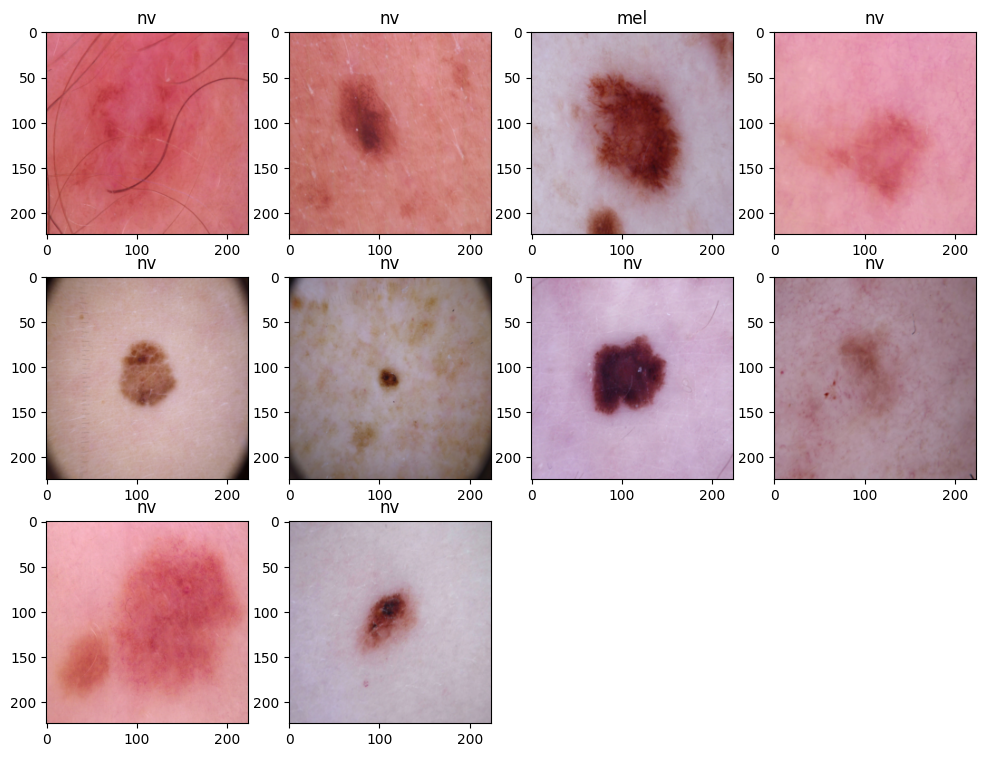

In [ ]:
explorer = Explorer(train_dataset)
explorer.show_images()

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, batch_size=32, num_workers=2)

### Defining the Model
Now, we will be defining a basic CNN based model for this dataset.

In [7]:
class BasicConvNet(nn.Module):
    """A Basic CNN based model for classification."""
    def __init__(self, num_classes=10, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=32, kernel_size=5, stride=1, padding=2), nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyConv2d(out_channels=64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.LazyConv2d(out_channels=96, kernel_size=7, stride=2, padding=1), nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyConv2d(out_channels=64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=512), nn.ReLU(),
            nn.LazyLinear(out_features=256), nn.ReLU(),
            nn.LazyLinear(out_features=num_classes)
        )

    def forward(self, X):
        return self.net(X)

In [14]:
model = BasicConvNet(num_classes=len(train_dataset.label_map))
prepare_model(model.net, (1, 3, 224, 224))

0: Conv2d output shape: torch.Size([1, 32, 224, 224])
1: ReLU output shape: torch.Size([1, 32, 224, 224])
2: Dropout output shape: torch.Size([1, 32, 224, 224])
3: Conv2d output shape: torch.Size([1, 64, 224, 224])
4: ReLU output shape: torch.Size([1, 64, 224, 224])
5: MaxPool2d output shape: torch.Size([1, 64, 222, 222])
6: Conv2d output shape: torch.Size([1, 96, 109, 109])
7: ReLU output shape: torch.Size([1, 96, 109, 109])
8: Dropout output shape: torch.Size([1, 96, 109, 109])
9: Conv2d output shape: torch.Size([1, 64, 109, 109])
10: ReLU output shape: torch.Size([1, 64, 109, 109])
11: MaxPool2d output shape: torch.Size([1, 64, 53, 53])
12: Flatten output shape: torch.Size([1, 179776])
13: Linear output shape: torch.Size([1, 512])
14: ReLU output shape: torch.Size([1, 512])
15: Linear output shape: torch.Size([1, 256])
16: ReLU output shape: torch.Size([1, 256])
17: Linear output shape: torch.Size([1, 7])


In [15]:
model.apply(init_module)

BasicConvNet(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=179776, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=256, bias=True)
    (16): ReLU()
    (17): Linear(in_features=256, out_features=7, bias=True)
  )
)

### Training the Model
Now, we are going to train this toy model on our dataset. Is this is just an experimental look for whether all the tools implemented are working fine, we will only train the model for a few epochs.

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
metrics = {
    "accuracy": accuracy_score,
    "precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro", zero_division=0.0)
} # zero_division needs to be set to 0 to avoid warning, as there are chances to have class imbalances for now
trainer = Trainer(
    max_epochs=10, clip_grad=True, device="cuda", metrics=metrics
)

In [17]:
trainer.fit(
    model, criterion, optimizer, train_dl, val_dl
)

Epoch 1/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.9615608240988625
Val loss: 0.9854015962657503
Epoch 2/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 0.9651036745510225
Val loss: 0.9516130878670932
Epoch 3/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 0.9358176435027893
Val loss: 0.9413373007076254
Epoch 4/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 0.889564171780454
Val loss: 0.9029929383516904
Epoch 5/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 0.842668188209944
Val loss: 0.8934459239318412
Epoch 6/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 0.7974141288300541
Val loss: 0.9406250246109501
Epoch 7/10
[------------------------------------

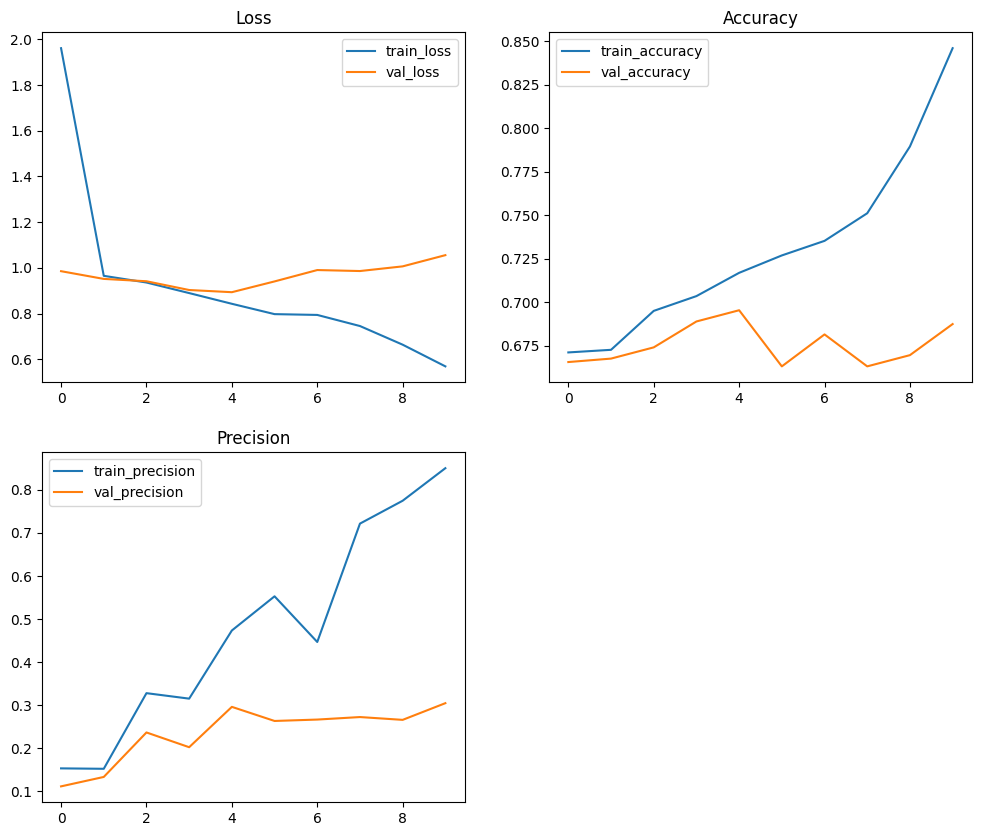

In [18]:
plot_history(trainer.current_history)

This low validation accuracy and precision is largely due to class imbalance. But for now all utilities are working fine.